# Convert raw Osmosis swap data to OHLCV market feed

- Read the raw CSV data export made out from TheGrapgh subgraph by `store_price.py`
- Create OHLCV candle chart based on the data
- [See also Osmosis asset info documentation](https://docs.osmosis.zone/developing/assets/asset-info.html).

In [62]:
import pandas as pd
import numpy as np

fpath = "/Users/moo/code/ts/hackatom-2022/swaps.csv"
output_fname = "/Users/moo/code/ts/hackatom-2022/pool_1_hourly_candles.parquet"

# Define CSV column types
dtype = {
    "block_number": np.int32,
    "timestamp": np.int32,
    "pool_id": np.int32,
    "token_in": str,
    "token_out": str,
    "token_in_amount": np.float64,
    "token_out_amount": np.float64,
}

df = pd.read_csv(fpath, dtype=dtype)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index("timestamp", inplace=True, drop=False)

df


,block_number,timestamp,pool_id,token_in,token_out,token_in_amount,token_out_amount
timestamp,,,,,,,
2021-12-25 00:12:25,2522560,2021-12-25 00:12:25,605,ibc/B9E0A1A524E98BB407D3CED8720EFEFD186002F90C...,uosmo,9.341900e+10,21116362.0
2021-12-25 00:12:31,2522561,2021-12-25 00:12:31,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,1.336698e+06,275489.0
2021-12-25 00:12:37,2522562,2021-12-25 00:12:37,1,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,uosmo,2.000000e+06,9646039.0
2021-12-25 00:12:37,2522562,2021-12-25 00:12:37,560,uosmo,ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8...,3.822892e+07,211282980.0
2021-12-25 00:12:51,2522564,2021-12-25 00:12:51,481,uosmo,ibc/5973C068568365FFF40DEDCF1A1CB7582B6116B731...,2.500000e+07,128144457.0
...,...,...,...,...,...,...,...
2022-04-28 12:12:54,4179519,2022-04-28 12:12:54,690,ibc/CBA34207E969623D95D057D9B11B0C8B32B89A71F1...,uosmo,1.050000e+08,8768313.0
2022-04-28 12:12:54,4179519,2022-04-28 12:12:54,560,uosmo,ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8...,6.591933e+06,30030266.0
2022-04-28 12:12:54,4179519,2022-04-28 12:12:54,560,uosmo,ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8...,1.801408e+06,8206495.0


Split swaps by trading pair (pool)

In [63]:
pool_df = df.groupby("pool_id")
print(f"We have total {len(pool_df.groups.keys())} pools")

We have total 430 pools


# Swap counts by pool id

Show which pools are leading in swap count.

array([[<AxesSubplot:title={'center':'pool_id'}>]], dtype=object)

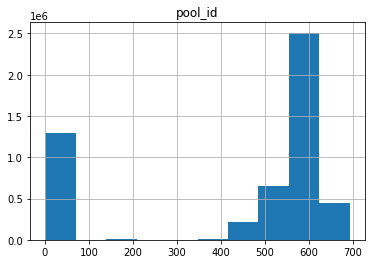

In [64]:
df.hist(column="pool_id")

# Top pools


In [65]:
print("Some Osmosis pool ids", list(pool_df.groups.keys())[0:10])

Some Osmosis pool ids [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [66]:
from collections import Counter

swap_counts = Counter({pid: len(df.loc[df["pool_id"]==pid]) for pid in pool_df.groups.keys()})

for pool_id, count in swap_counts.most_common(6):
    pool_data = df.loc[df["pool_id"]== pool_id ]
    first_swap = pool_data.iloc[0]
    print(f"Pool id {pool_id} {first_swap['token_in']}-{first_swap['token_out']} has {count:,} swaps")

Pool id 1 uosmo-ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEADA9CA97EA622B25F41E5EB2 has 819,837 swaps
Pool id 560 uosmo-ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8C539F6E6A9345048894FCC has 761,583 swaps
Pool id 497 ibc/46B44899322F3CD854D2D46DEEF881958467CDD4B3B10086DA49296BBED94BED-uosmo has 354,178 swaps
Pool id 498 ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEADA9CA97EA622B25F41E5EB2-ibc/46B44899322F3CD854D2D46DEEF881958467CDD4B3B10086DA49296BBED94BED has 271,839 swaps
Pool id 561 uosmo-ibc/0EF15DF2F02480ADE0BB6E85D9EBB5DAEA2836D3860E9F97F9AADE4F57A31AA0 has 208,299 swaps
Pool id 604 uosmo-ibc/987C17B11ABC2B20019178ACE62929FE9840202CE79498E29FE8E5CB02B7C0A4 has 188,662 swaps


# Calculate price and value for each swap

Draw candles for pool 1. This is [ATOM-OSMO pair](https://docs.osmosis.zone/developing/assets/asset-info.html).

- Determine direction of each swap event
- Calculate price as ATOM/OSMO and swap volume

Show 10 first swaps as an example of processed data.

In [67]:
pool_id = 1
pair_data = df.loc[df["pool_id"] == pool_id]

# Swap price can be manipulated if we go too deep into fractional number territory
# and fixed point math starts breaking out.
# Assume anything lower than 1000 uosmo might be broken.
low_problem_threshold = 1000


def is_good_swap(row: pd.Series):
    if row["token_out_amount"] < low_problem_threshold or \
        row["token_in_amount"] < low_problem_threshold:
        return False
    return True


def calculate_price(row: pd.Series):
    if row["token_in"] == "uosmo":
        # Buying ATOM with OSMO
        price = row["token_out_amount"] / row["token_in_amount"]
    else:
        # Selling OSMO for ATOM
        price = row["token_in_amount"] / row["token_out_amount"]

    return price

def calculate_value(row: pd.Series):
    """Get swap value (volume) in OSMO"""

    if row["token_out_amount"] < low_problem_threshold or \
        row["token_in_amount"] < low_problem_threshold:
        return pd.NA

    if row["token_in"] == "uosmo":
        # Buying ATOM with OSMO
        vol = row["token_in_amount"]
    else:
        # Selling OSMO for ATOM
        vol = row["token_out_amount"]

    return vol

# Filter out swaps with too low value
pair_data = pair_data.loc[\
    (pair_data["token_in_amount"] > low_problem_threshold) & \
    (pair_data["token_out_amount"] > low_problem_threshold)]

pair_data["price"] = pair_data.apply(calculate_price, axis=1)
pair_data["value"] = pair_data.apply(calculate_value, axis=1)
pair_data.head(10)

,block_number,timestamp,pool_id,token_in,token_out,token_in_amount,token_out_amount,price,value
timestamp,,,,,,,,,
2021-12-25 00:12:31,2522561,2021-12-25 00:12:31,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,1336698.0,275489.0,0.206097,1336698.0
2021-12-25 00:12:37,2522562,2021-12-25 00:12:37,1,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,uosmo,2000000.0,9646039.0,0.207339,9646039.0
2021-12-25 00:13:03,2522566,2021-12-25 00:13:03,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,194546844.0,40095045.0,0.206095,194546844.0
2021-12-25 00:13:03,2522566,2021-12-25 00:13:03,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,21116362.0,4352012.0,0.206097,21116362.0
2021-12-25 00:13:10,2522567,2021-12-25 00:13:10,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,485485352.0,100052608.0,0.206088,485485352.0
2021-12-25 00:13:16,2522568,2021-12-25 00:13:16,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,238348167.0,49118014.0,0.206077,238348167.0
2021-12-25 00:13:16,2522568,2021-12-25 00:13:16,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,30993399.0,6386937.0,0.206074,30993399.0
2021-12-25 00:13:16,2522568,2021-12-25 00:13:16,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,194165890.0,40013908.0,0.206081,194165890.0
2021-12-25 00:13:22,2522569,2021-12-25 00:13:22,1,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,uosmo,1000000.0,4823557.0,0.207316,4823557.0


# Convert trades to house candles


In [68]:
from eth_defi.research.candle import convert_to_ohlcv_candles

candles = convert_to_ohlcv_candles(pair_data, time_bucket=pd.Timedelta("1h"))
daily_candles = convert_to_ohlcv_candles(pair_data, time_bucket=pd.Timedelta("1D"))

candles.head(10)

,open,high,low,close,volume
timestamp,,,,,
2021-12-25 00:00:00,0.206097,0.207339,0.205816,0.207064,2.043362e+10
2021-12-25 01:00:00,0.205823,0.207563,0.205823,0.207533,1.329039e+10
2021-12-25 02:00:00,0.206290,0.207530,0.206053,0.206243,1.873274e+10
2021-12-25 03:00:00,0.207491,0.208288,0.206265,0.206945,3.154728e+10
2021-12-25 04:00:00,0.206848,0.208117,0.205908,0.207281,5.583936e+10
2021-12-25 05:00:00,0.206039,0.207729,0.206033,0.206461,1.372474e+11
2021-12-25 06:00:00,0.206465,0.207973,0.206321,0.206321,4.332167e+10
2021-12-25 07:00:00,0.207565,0.207574,0.206174,0.207419,1.524887e+10
2021-12-25 08:00:00,0.207439,0.207523,0.206165,0.207510,1.521909e+10


# Draw daily candle chart

- Show the price chart of ATOM/OSMO in [OHLCV format](https://tradingstrategy.ai/docs/glossary.html#term-OHLCV)
- Use Plotly for interactive chart

**Note**: Interactive charts do not work in Github notebook viewer.

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

candlesticks = go.Candlestick(
    x=candles.index,
    open=candles['open'],
    high=candles['high'],
    low=candles['low'],
    close=candles['close'],
    showlegend=False
)

volume_bars = go.Bar(
    x=candles.index,
    y=candles['volume'],
    showlegend=False,
    marker={
        "color": "rgba(128,128,128,0.5)",
    }
)

fig = go.Figure(candlesticks)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(candlesticks, secondary_y=True)
fig.add_trace(volume_bars, secondary_y=False)
fig.update_layout(title="ATOM/OSMO pool price development post Osmosis launch (hourly candles)", height=800)
fig.update_yaxes(title="Price ATOM/OSMO", secondary_y=True, showgrid=True)
fig.update_yaxes(title="Volume OSMO", secondary_y=False, showgrid=False)
fig.show()

In [70]:
# Draw daily candles


candlesticks = go.Candlestick(
    x=daily_candles.index,
    open=daily_candles['open'],
    high=daily_candles['high'],
    low=daily_candles['low'],
    close=daily_candles['close'],
    showlegend=False
)

volume_bars = go.Bar(
    x=daily_candles.index,
    y=daily_candles['volume'],
    showlegend=False,
    marker={
        "color": "rgba(128,128,128,0.5)",
    }
)

daily_fig = go.Figure(candlesticks)
daily_fig = make_subplots(specs=[[{"secondary_y": True}]])
daily_fig.add_trace(candlesticks, secondary_y=True)
daily_fig.add_trace(volume_bars, secondary_y=False)
daily_fig.update_layout(title="ATOM/OSMO pool price development post Osmosis launch (daily candles)", height=800)
daily_fig.update_yaxes(title="Price ATOM/OSMO", secondary_y=True, showgrid=True)
daily_fig.update_yaxes(title="Volume OSMO", secondary_y=False, showgrid=False)
daily_fig.show()

# Github output

Render the interactive chart above as PNG for Github repo viewer.


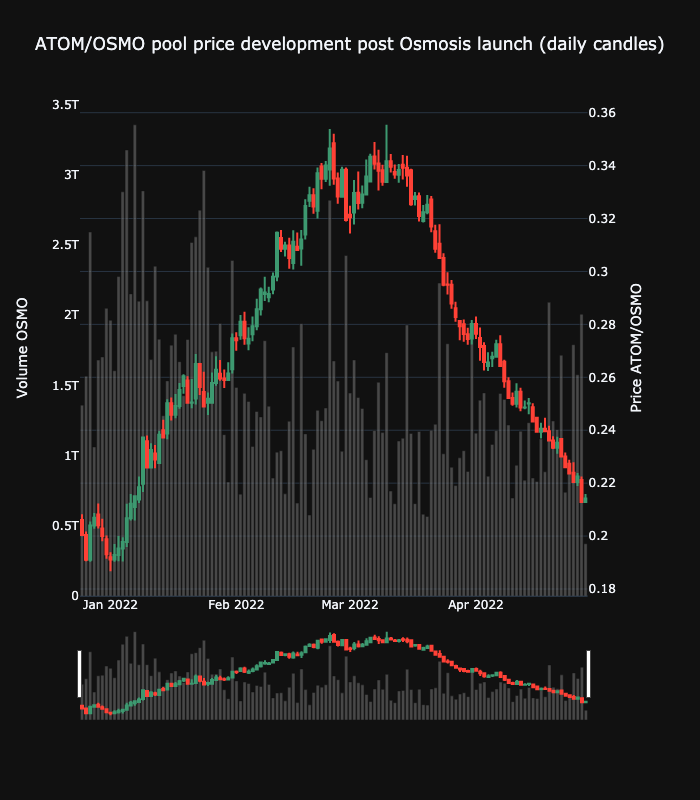

In [71]:
daily_fig.show("png")

# Save data

Save the candle data as Parquet.


In [73]:
candles.reset_index(inplace=True)  # https://datatofish.com/index-to-column-pandas-dataframe/
candles.to_parquet(output_fname)
print(f"Saved candles to {output_fname} with columns {candles.columns}")

Saved candles to /Users/moo/code/ts/hackatom-2022/pool_1_hourly_candles.parquet with colums Index(['index', 'timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')
